In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Doppler Radar: Continuous Wave Velocity Measurement

## Introduction

This notebook demonstrates **Doppler radar**—a fundamental radar type that uses the **Doppler effect** to measure target velocity directly by detecting frequency shifts in reflected signals. Unlike range-measuring radars, Doppler radar excels at velocity measurement, making it essential for traffic monitoring, weather tracking, and motion detection.

### The Doppler Effect

**The Doppler effect** is the change in wave frequency due to relative motion between source and observer. For radar, this manifests as a frequency shift in the returned signal.

**Doppler Shift Formula:**

For a target moving with radial velocity $v_r$:

$$f_d = \frac{2v_r f_c}{c}$$

Where:
- $f_d$ = Doppler frequency shift (Hz)
- $v_r$ = Radial velocity (m/s, positive = receding, negative = approaching)
- $f_c$ = Carrier frequency (Hz)
- $c$ = Speed of light (3×10⁸ m/s)

**Factor of 2:**

The factor of 2 appears because the wave travels to the target AND back, experiencing the Doppler effect twice (transmit and receive).

**Sign Convention:**

- **Negative $f_d$**: Target approaching (closing)
- **Positive $f_d$**: Target receding (opening)
- **Zero $f_d$**: No radial motion (stationary or perpendicular motion)

### Continuous Wave (CW) Doppler Radar

**CW radar** transmits a constant-frequency unmodulated signal, making it the simplest Doppler radar configuration.

**Characteristics:**

1. **Single-Tone Transmission**: Constant frequency (no modulation)
2. **Continuous Operation**: Always transmitting and receiving
3. **No Range Information**: Cannot measure distance (velocity only)
4. **Simple Hardware**: Minimal signal generation complexity
5. **High Sensitivity**: Long integration time for weak signals

**Operating Principle:**

1. Transmit continuous wave at $f_c$
2. Target reflects signal with Doppler shift $f_d$
3. Mixer combines transmitted and received signals
4. Output: Beat frequency = $f_d$ (baseband)
5. FFT extracts $f_d$ → Calculate velocity

### Doppler Radar Applications

**Traffic Monitoring:**
- **Speed Enforcement**: Police radar guns (Ka-band, 35 GHz)
- **Traffic Flow**: Vehicle counting and speed measurement
- **Toll Systems**: Vehicle classification by velocity profile

**Weather Radar:**
- **Wind Velocity**: Measure precipitation movement
- **Storm Tracking**: Detect rotation in tornadoes
- **Aviation**: Wind shear detection for safety

**Motion Detection:**
- **Security Systems**: Intrusion detection (microwave sensors)
- **Automatic Doors**: Presence and approach detection
- **Lighting Control**: Occupancy sensing

**Sports:**
- **Ball Speed**: Baseball, tennis, cricket
- **Vehicle Speed**: Motorsports timing
- **Athlete Performance**: Sprint speed measurement

**Medical:**
- **Blood Flow**: Doppler ultrasound for circulation
- **Heart Monitoring**: Cardiac motion detection
- **Fetal Monitoring**: Heartbeat detection

### Advantages and Limitations

**Advantages:**

1. **Direct Velocity Measurement**: No processing complexity
2. **Simple Design**: Minimal hardware requirements
3. **High Sensitivity**: Long coherent integration
4. **Real-Time Operation**: Immediate velocity output
5. **Cost-Effective**: Simple signal chain

**Limitations:**

1. **No Range Information**: Cannot measure distance
2. **Ambiguity**: Multiple targets create mixed frequencies
3. **Radial Velocity Only**: Misses perpendicular motion
4. **Clutter Sensitive**: Ground clutter at zero Doppler
5. **Limited Dynamic Range**: Strong/weak target discrimination

### Signal Processing Chain

**Doppler Radar Processing:**

1. **Transmit CW Signal**: Constant frequency $f_c$
2. **Receive Reflected Signal**: Frequency $f_c + f_d$
3. **Mixing (Homodyne)**: Multiply TX and RX signals
4. **Baseband Output**: Contains Doppler frequency $f_d$
5. **FFT Processing**: Extract spectral peaks
6. **Peak Detection**: Identify target Doppler frequencies
7. **Velocity Calculation**: $v_r = f_d c / (2f_c)$

**Frequency Domain:**

The FFT of the baseband signal reveals peaks at Doppler frequencies corresponding to target velocities. Multiple targets create multiple peaks.

### Doppler Ambiguity Resolution

**Aliasing:**

If Doppler frequency exceeds sampling rate: $f_d > f_s/2$

**Solution:**

- **Increase Sampling Rate**: Capture higher Doppler
- **Multiple Frequencies**: Use several carrier frequencies
- **PRF Diversity**: Staggered pulse repetition

### Multi-Target Scenarios

**Frequency Separation:**

Different target velocities create distinct Doppler frequencies:
- Target 1: $v_1$ → $f_{d1}$
- Target 2: $v_2$ → $f_{d2}$
- FFT shows two peaks if $|f_{d1} - f_{d2}| > \Delta f$ (frequency resolution)

**Resolution:**

Doppler resolution depends on observation time:

$$\Delta f_d = \frac{1}{T_{obs}}$$

Longer observation → Better velocity resolution

### You'll Learn How To:

- Configure simple CW Doppler radar at 10 GHz
- Set up single-tone continuous transmission (0.1s pulse)
- Model point targets with different velocities
- Simulate baseband I/Q signals with Doppler shifts
- Visualize time-domain baseband waveforms
- Apply FFT to extract Doppler frequencies
- Convert frequency to velocity: $v = f_d c/(2f_c)$
- Generate velocity spectrum showing multiple targets
- Identify approaching vs. receding targets
- Understand velocity resolution and ambiguity

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to demonstrate:

**Scenario:**
- 10 GHz CW Doppler radar (X-band)
- Single 0.1-second pulse (continuous wave)
- 40 kHz sampling rate

**Targets:**
- Target 1: 30m range, -10 m/s (approaching)
- Target 2: 35m range, +35 m/s (receding)

**Processing:**
- FFT of baseband to extract Doppler spectrum
- Velocity axis: -300 to +300 m/s
- Two distinct peaks at target velocities

**Expected Results:**
- Negative Doppler peak at -10 m/s (approaching)
- Positive Doppler peak at +35 m/s (receding)
- Clear velocity separation demonstrates multi-target capability

The simulation demonstrates fundamental Doppler radar operation for velocity measurement without range information.

## Radar System Configuration

Configure a simple CW Doppler radar for velocity measurement.

### Import Required Modules

Import necessary RadarSimPy modules and NumPy for numerical operations.

In [2]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter Configuration

Configure CW transmitter for continuous-wave Doppler radar.

**Transmitter Parameters:**

- **Frequency**: 10 GHz (X-band)
  - Single-tone (no modulation)
  - Carrier frequency for Doppler shift calculation
  - λ = c/f = 3 cm wavelength

- **Pulse Length**: 0.1 seconds
  - Continuous transmission duration
  - Long observation for good velocity resolution
  - Doppler resolution: Δf_d = 1/T = 10 Hz

- **Transmit Power**: 10 dBm (~10 mW)
  - Low power sufficient for CW operation

- **Number of Pulses**: 1
  - Single continuous observation
  - No pulse-to-pulse processing

- **Antenna**: Single channel at origin
  - Monostatic configuration (TX and RX co-located)

**Velocity Resolution:**

$$\Delta v = \frac{c \Delta f_d}{2f_c} = \frac{3 \times 10^8 \times 10}{2 \times 10 \times 10^9} = 0.15 \text{ m/s}$$

This fine resolution enables precise velocity measurement.

In [3]:
# Configure CW Doppler transmitter
tx = Transmitter(
    f=10e9,                      # Carrier frequency: 10 GHz (X-band, single-tone)
    t=0.1,                       # Pulse length: 0.1 seconds (CW observation)
    tx_power=10,                 # Transmit power: 10 dBm (~10 mW)
    pulses=1,                    # Single pulse (continuous wave)
    channels=[dict(location=(0, 0, 0))],  # Single antenna at origin
)

### Receiver Configuration

Configure receiver for baseband Doppler frequency detection.

**Receiver Parameters:**

- **Sampling Rate**: 40 kHz (40,000 samples/second)
  - Captures baseband Doppler frequencies
  - Nyquist frequency: 20 kHz
  - Maximum Doppler: ±20 kHz → ±300 m/s at 10 GHz
  - Calculation: v_max = f_s/2 × c/(2f_c) = 20,000 × 3×10⁸/(2×10¹⁰) = 300 m/s

- **Noise Figure**: 6 dB
  - Low noise for sensitive velocity detection

- **RF Gain**: 20 dB
  - LNA amplification

- **Baseband Gain**: 50 dB
  - High gain for Doppler signal amplification
  - Total gain: 70 dB

- **Load Resistor**: 1000 Ω
  - High impedance for voltage sensitivity

- **Antenna**: Single channel at origin (co-located with TX)

In [4]:
# Configure Doppler radar receiver
rx = Receiver(
    fs=40000,                    # Sampling rate: 40 kHz (±20 kHz Doppler, ±300 m/s)
    noise_figure=6,              # Noise figure: 6 dB (low noise)
    rf_gain=20,                  # RF gain: 20 dB
    baseband_gain=50,            # Baseband gain: 50 dB (high sensitivity)
    load_resistor=1000,          # Load resistance: 1000 Ω (high impedance)
    channels=[dict(location=(0, 0, 0))],  # Single antenna at origin
)

### Create Radar System

Combine transmitter and receiver to form the complete CW Doppler radar.

In [5]:
# Create complete CW Doppler radar system
radar = Radar(transmitter=tx, receiver=rx)

## Target Configuration

Define two point targets with different velocities to demonstrate multi-target Doppler detection.

### Target Parameters

**Target 1 (Approaching):**
- **Location**: (30, 0, 0) m → 30m range
- **RCS**: 20 dBsm (moderate reflector)
- **Velocity**: (-10, 0, 0) m/s → Approaching at 10 m/s
- **Expected Doppler**: $f_{d1} = \frac{2 \times (-10) \times 10 \times 10^9}{3 \times 10^8} = -666.7$ Hz
- **Sign**: Negative (approaching/closing)

**Target 2 (Receding):**
- **Location**: (35, 0, 0) m → 35m range
- **RCS**: 20 dBsm (moderate reflector)
- **Velocity**: (+35, 0, 0) m/s → Receding at 35 m/s
- **Expected Doppler**: $f_{d2} = \frac{2 \times 35 \times 10 \times 10^9}{3 \times 10^8} = +2333.3$ Hz
- **Sign**: Positive (receding/opening)

**Frequency Separation:**

$$\Delta f_d = |f_{d2} - f_{d1}| = |2333.3 - (-666.7)| = 3000 \text{ Hz}$$

This separation (3 kHz) is much larger than the Doppler resolution (10 Hz), ensuring clear separation in the spectrum.

**Phase:**

Initial phase = 0° for both targets (synchronized reference).

In [6]:
# Configure Target 1: Approaching vehicle
target1 = dict(
    location=(30, 0, 0),  # Position: 30m along x-axis
    rcs=20,               # Radar cross section: 20 dBsm
    speed=(-10, 0, 0),    # Velocity: -10 m/s (approaching, negative Doppler)
    phase=0,              # Initial phase: 0 degrees
)

# Configure Target 2: Receding vehicle
target2 = dict(
    location=(35, 0, 0),  # Position: 35m along x-axis
    rcs=20,               # Radar cross section: 20 dBsm
    speed=(35, 0, 0),     # Velocity: +35 m/s (receding, positive Doppler)
    phase=0,              # Initial phase: 0 degrees
)

# Combine targets for simulation
targets = [target1, target2]

## Simulate Baseband Signals

Generate baseband I/Q signals containing Doppler frequency shifts from both targets.

### Simulation Process

The simulator computes:
1. **Signal propagation**: TX → Targets → RX
2. **Doppler shift**: Frequency shift based on target velocity
3. **Phase modulation**: Time-varying phase from motion
4. **Amplitude scaling**: Based on range and RCS
5. **Coherent sum**: Superposition of returns from both targets
6. **Noise addition**: System thermal noise

**Output Data Structure:**

- **Dimensions**: [channels, pulses, samples]
  - Channels: 1 (single TX/RX)
  - Pulses: 1 (single CW observation)
  - Samples: 4000 (0.1s × 40 kHz)

**Baseband Content:**

The baseband signal contains two sinusoids:
- Frequency 1: -666.7 Hz (Target 1, approaching)
- Frequency 2: +2333.3 Hz (Target 2, receding)
- Plus noise from receiver

In [7]:
# Import radar simulator
from radarsimpy.simulator import sim_radar

# Simulate Doppler radar returns from both targets
data = sim_radar(radar, targets)

# Extract timestamp and baseband signals
timestamp = data["timestamp"]  # Time axis for each sample
baseband = data["baseband"] + data["noise"]  # Complex I/Q with noise [1, 1, 4000]

### Visualize Baseband I/Q Signals

Display time-domain baseband waveforms showing Doppler-modulated signals.

**I/Q Components:**

- **I (In-phase)**: Real part of complex baseband
- **Q (Quadrature)**: Imaginary part of complex baseband
- Together encode amplitude and phase information

**Expected Pattern:**

The baseband shows a **beat frequency pattern** from the superposition of two Doppler-shifted sinusoids:
- Slow beating from 666.7 Hz (Target 1)
- Faster oscillation from 2333.3 Hz (Target 2)
- Combined creates complex time-domain waveform

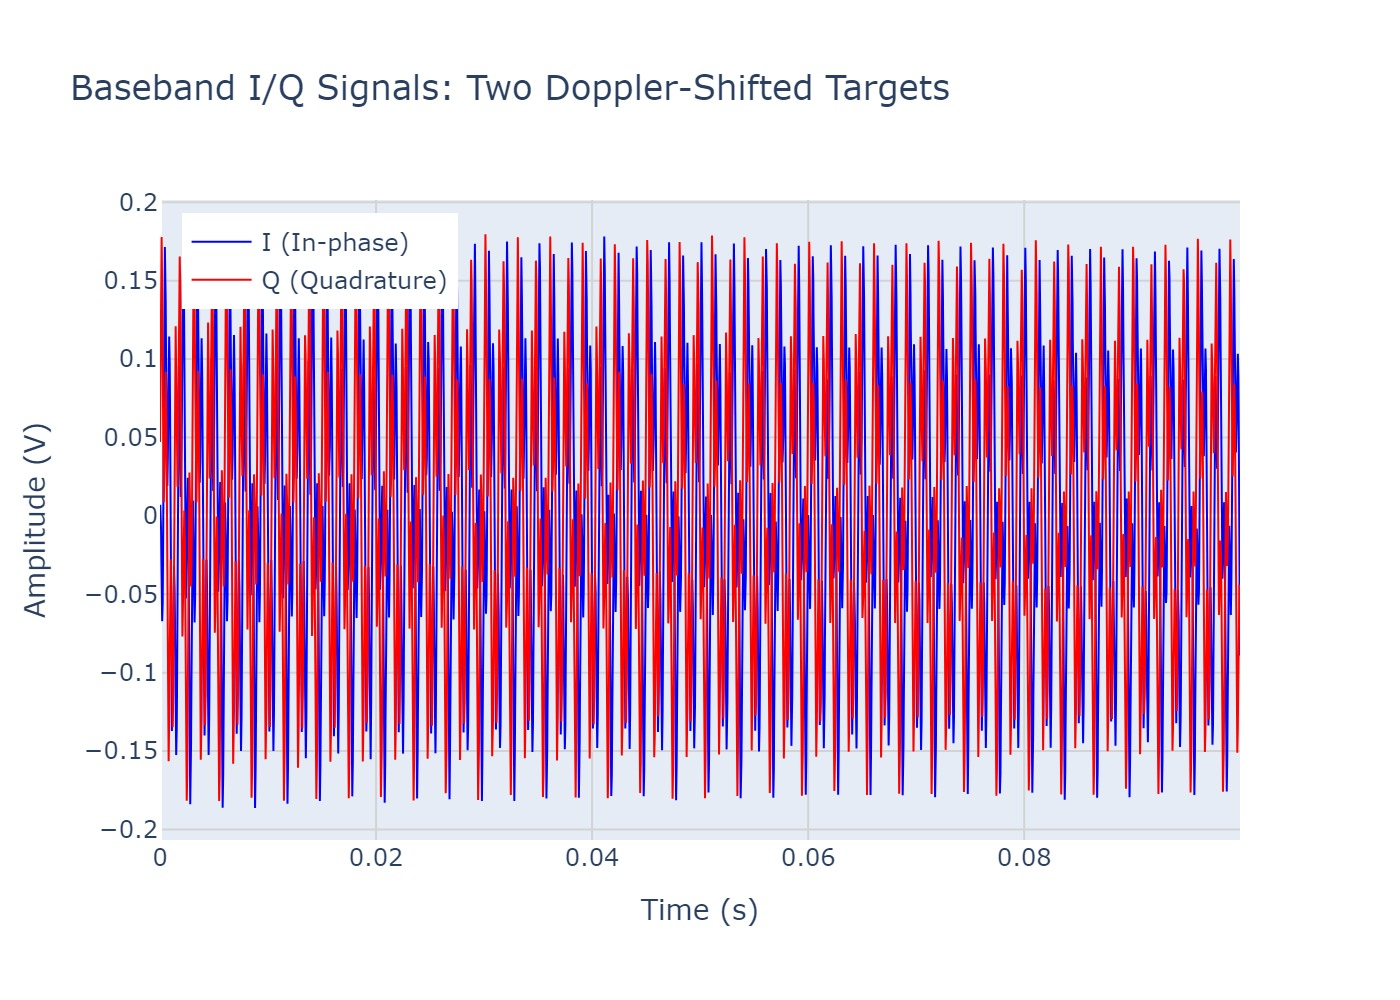

In [8]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Create figure for I/Q baseband visualization
fig = go.Figure()

# Plot In-phase (I) component (real part)
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],           # Time axis (seconds)
        y=np.real(baseband[0, 0, :]),  # Real part (I channel)
        name="I (In-phase)",
        line=dict(color='blue', width=1),
    )
)

# Plot Quadrature (Q) component (imaginary part)
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],           # Time axis (seconds)
        y=np.imag(baseband[0, 0, :]),  # Imaginary part (Q channel)
        name="Q (Quadrature)",
        line=dict(color='red', width=1),
    )
)

# Configure plot layout
fig.update_layout(
    title="Baseband I/Q Signals: Two Doppler-Shifted Targets",
    yaxis=dict(title="Amplitude (V)", gridcolor='lightgray'),
    xaxis=dict(title="Time (s)", gridcolor='lightgray'),
    height=500,
    legend=dict(x=0.02, y=0.98),
    hovermode='x unified',
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Doppler Signal Processing

Apply FFT to extract Doppler frequencies and convert to target velocities.

### FFT Processing

**Frequency Domain Analysis:**

1. **FFT**: Transforms time-domain baseband to frequency domain
2. **fftshift**: Centers zero frequency (DC component)
3. **Doppler Spectrum**: Shows peaks at Doppler frequencies

**Velocity Conversion:**

From Doppler frequency to velocity:

$$v = \frac{f_d \cdot c}{2f_c}$$

Where:
- $v$ = Radial velocity (m/s)
- $f_d$ = Doppler frequency (Hz)
- $c$ = Speed of light (3×10⁸ m/s)
- $f_c$ = Carrier frequency (10 GHz)

**Expected Peaks:**

- Peak 1: -10 m/s (Target 1, approaching)
- Peak 2: +35 m/s (Target 2, receding)

In [9]:
# Import FFT functions and constants
from scipy.fft import fft, fftshift
from scipy.constants import speed_of_light

# Perform FFT on baseband signal and shift zero frequency to center
spec = fftshift(fft(baseband[0, 0, :]))  # Complex spectrum [4000 frequency bins]

# Create velocity axis by converting frequency to velocity
# Doppler frequency axis: -fs/2 to +fs/2
# Velocity: v = f_d * c / (2*f_c)
speed = (
    np.linspace(
        -rx.bb_prop["fs"] / 2,              # -20 kHz (maximum approaching)
        rx.bb_prop["fs"] / 2,               # +20 kHz (maximum receding)
        radar.sample_prop["samples_per_pulse"],  # 4000 bins
        endpoint=False,
    )
    * speed_of_light                        # Multiply by c (3e8 m/s)
    / 2                                     # Divide by 2 (two-way propagation)
    / 10e9                                  # Divide by f_c (10 GHz)
)
# Velocity axis spans: -300 m/s to +300 m/s

### Visualize Doppler Velocity Spectrum

Display the Doppler spectrum showing target velocities.

**Spectrum Interpretation:**

- **Horizontal Axis**: Velocity (m/s)
  - Negative: Approaching targets (closing)
  - Positive: Receding targets (opening)
  - Zero: Stationary targets or clutter

- **Vertical Axis**: Magnitude (dB)
  - Peak height indicates target strength
  - Influenced by RCS, range, and SNR

**Expected Features:**

1. **Peak at -10 m/s**: Target 1 (approaching)
2. **Peak at +35 m/s**: Target 2 (receding)
3. **Noise Floor**: Background from receiver noise
4. **Clean Separation**: 45 m/s velocity difference ensures distinct peaks

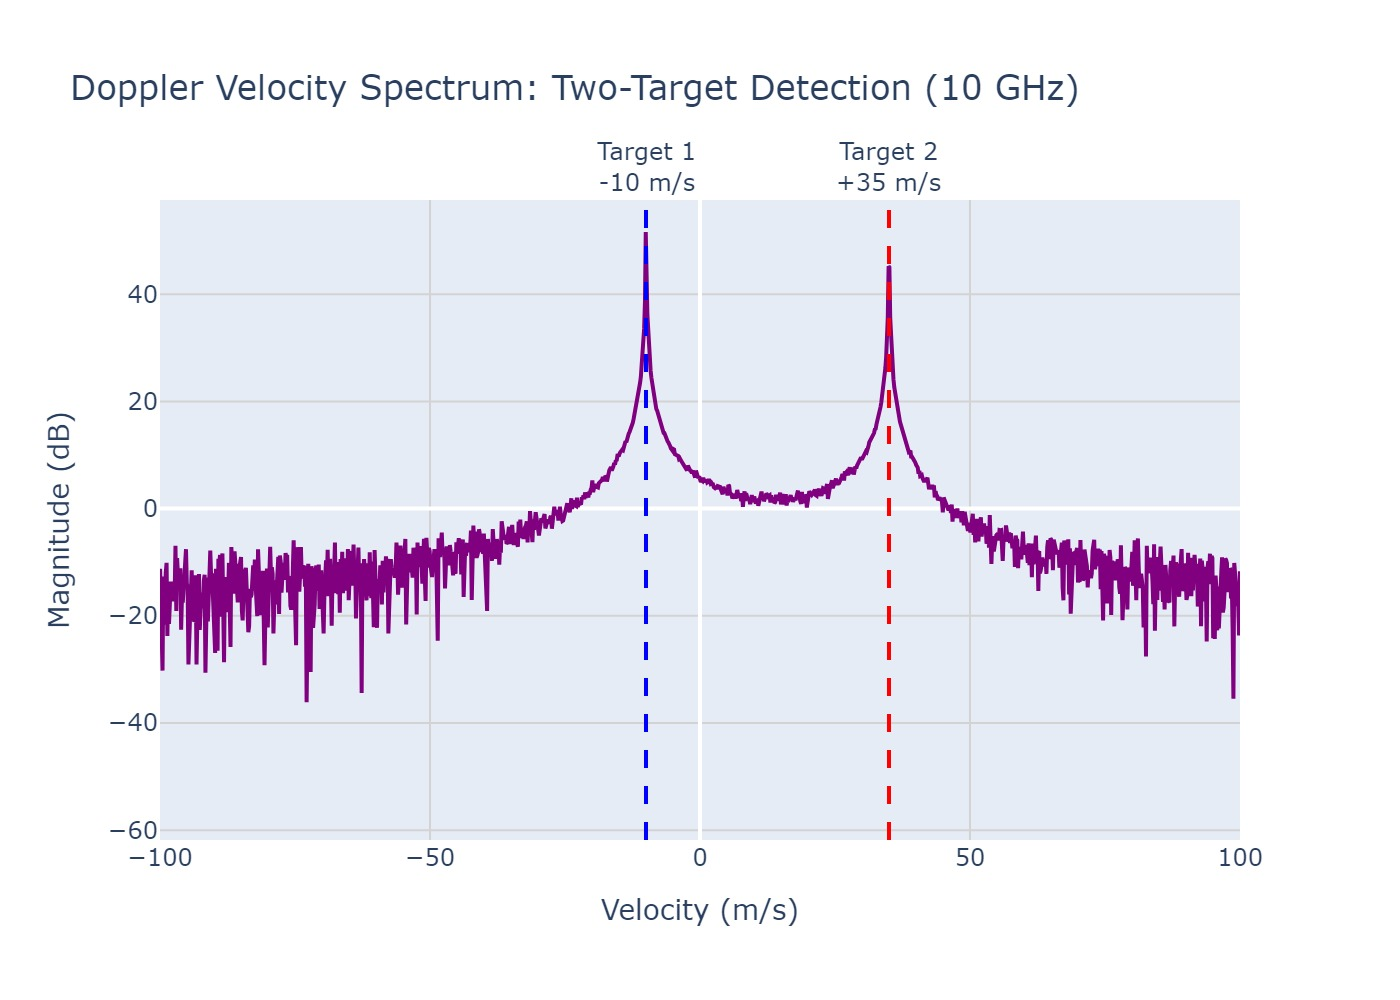

In [10]:
# Create figure for Doppler spectrum
fig = go.Figure()

# Plot magnitude spectrum in dB
fig.add_trace(
    go.Scatter(
        x=speed,                            # Velocity axis (m/s)
        y=20 * np.log10(np.abs(spec)),     # Magnitude in dB
        name="Doppler Spectrum",
        line=dict(color='purple', width=2),
        mode='lines',
    )
)

# Add vertical lines at expected target velocities
fig.add_vline(x=-10, line_dash="dash", line_color="blue", 
              annotation_text="Target 1<br>-10 m/s", annotation_position="top")
fig.add_vline(x=35, line_dash="dash", line_color="red",
              annotation_text="Target 2<br>+35 m/s", annotation_position="top")

# Configure plot layout
fig.update_layout(
    title="Doppler Velocity Spectrum: Two-Target Detection (10 GHz)",
    yaxis=dict(title="Magnitude (dB)", gridcolor='lightgray'),
    xaxis=dict(title="Velocity (m/s)", range=[-100, 100], gridcolor='lightgray'),
    height=500,
    showlegend=False,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to implement and analyze CW Doppler radar using RadarSimPy:

### Key Takeaways

**1. Doppler Effect Fundamentals**
- Understood Doppler shift: $f_d = 2v_r f_c / c$
- Learned factor of 2 from two-way propagation
- Recognized sign convention (negative = approaching, positive = receding)
- Appreciated frequency shift proportional to velocity

**2. CW Doppler Radar Principles**
- Configured single-tone continuous wave transmission
- Understood velocity-only measurement (no range)
- Learned advantages: simplicity, sensitivity, real-time
- Recognized limitations: no range, ambiguity, radial velocity only

**3. System Configuration**
- Set up 10 GHz X-band transmitter (0.1s CW pulse)
- Configured 40 kHz sampling rate (±300 m/s unambiguous velocity)
- Applied 70 dB total gain for sensitive detection
- Used monostatic configuration (co-located TX/RX)

**4. Multi-Target Scenario**
- Modeled two targets with different velocities (-10 m/s, +35 m/s)
- Calculated expected Doppler frequencies (-666.7 Hz, +2333.3 Hz)
- Observed 3 kHz frequency separation (well-resolved)
- Demonstrated simultaneous detection capability

**5. Baseband Signal Generation**
- Simulated complex I/Q baseband with Doppler modulation
- Visualized time-domain waveforms (beat pattern)
- Added realistic receiver noise
- Observed superposition of two sinusoids

**6. FFT Processing**
- Applied FFT to extract Doppler spectrum
- Used fftshift to center zero frequency
- Converted frequency to velocity: $v = f_d c/(2f_c)$
- Generated velocity axis (-300 to +300 m/s)

**7. Velocity Resolution**
- Calculated Doppler resolution: Δf_d = 1/T_obs = 10 Hz
- Derived velocity resolution: Δv = 0.15 m/s
- Understood observation time impact on resolution
- Recognized trade-off: longer time → better resolution

**8. Spectrum Interpretation**
- Identified two clear peaks at target velocities
- Distinguished approaching (negative) from receding (positive)
- Measured peak amplitudes (influenced by RCS and range)
- Observed noise floor from receiver

### Experiment Further

Try modifying the parameters to explore different scenarios:

**1. Velocity Variations**:
- Test different velocities: 5, 20, 50, 100 m/s
- Observe Doppler frequency scaling
- Verify $f_d = 2vf_c/c$ relationship
- Test negative vs. positive velocities

**2. Frequency Band Studies**:
- Change carrier: 5 GHz, 24 GHz, 77 GHz
- Observe Doppler sensitivity: $f_d \propto f_c$
- Compare velocity resolution across bands
- Test aliasing at higher frequencies

**3. Observation Time**:
- Vary pulse length: 0.01s, 0.5s, 1s
- Observe velocity resolution: Δv = c/(2f_c T)
- Trade-off: resolution vs. update rate
- Test closely-spaced targets

**4. Sampling Rate Effects**:
- Reduce to 10 kHz, 20 kHz
- Observe velocity ambiguity (aliasing)
- Maximum velocity: v_max = f_s c/(4f_c)
- Test Nyquist criterion

**5. Target Count**:
- Add 3rd, 4th, 5th targets
- Test resolution limits
- Observe peak overlap
- Practice multi-target discrimination

**6. Close Velocities**:
- Set targets at 10 m/s and 11 m/s
- Test velocity resolution limits
- Observe peak separation
- Understand spectral leakage

**7. RCS Variations**:
- Vary RCS: 0, 10, 30 dBsm
- Observe amplitude differences
- Test weak target detection
- Understand dynamic range

**8. Perpendicular Motion**:
- Set velocity (0, 10, 0) - perpendicular
- Observe zero Doppler (no radial component)
- Understand radial velocity limitation
- Test oblique angles

**9. Approaching and Receding**:
- Configure targets with same speed, opposite directions
- Observe symmetric Doppler peaks
- Test positive/negative discrimination
- Analyze beat frequency pattern

**10. Windowing Functions**:
- Apply Hamming, Hanning, Blackman windows
- Observe sidelobe reduction
- Trade-off: resolution vs. sidelobes
- Test spectral leakage mitigation

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- Doppler Effect: Frequency shift from relative motion
- CW Radar: Continuous wave radar principles
- FFT Processing: Spectral analysis techniques
- Velocity Measurement: Doppler-based speed detection
- Traffic Radar: Police radar and speed enforcement
- Weather Radar: Doppler weather systems
- Motion Sensors: Microwave motion detection
- Signal Processing: Time-frequency analysis